In [23]:
from pathlib import Path
from definitions import ROOT_DIR
import pandas as pd
import numpy as np
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'sans-serif',
             'sans-serif':['Arial'],
             'size':16})

In [24]:
def get_class_size(metadata, class_column):
    sizes = metadata[class_column].value_counts()
    metadata['class_size'] = [sizes[k] for k in metadata[class_column]]
    return metadata


def filter_neutral_losses(df, neutral_losses=['']):
    '''
    Filter out entries for ions with neutral losses that are not in the list provided
    If neutral_loss value us "only_nl", than consider only ions that have neutral losses
    '''
    
    if neutral_losses == "only_nl":
        df = df[df.neutral_loss != ""]
    elif neutral_losses != None:
        df = df[df.neutral_loss.isin(neutral_losses)]
    return df


def filter_adducts(df, adducts=['']):
    '''
    Filter out entries for ions with adducts that are not in the list provided
    '''
    if adducts != None:
        df = df[df.adduct.isin(adducts)]
    return df


def filter_polarity(df, polarity=None):
    '''
    Filter out entries based on polarity pol ['positive', 'negative']
    '''
    if polarity != None:
        df = df[df.Polarity == polarity]
    return df


def filter_data(data, polarity=None, adducts=None, neutral_losses=None):
    '''
    Apply polarity, adduct and neutral_loss filters
    '''
    data = filter_polarity(data, polarity)
    data = filter_adducts(data, adducts)
    data = filter_neutral_losses(data, neutral_losses)
    
    return data


def group_by_molecule(df, groupby_columns):
    '''
    Aggregate intensity and detection values per groupby columns
    '''          
    data = df.groupby(groupby_columns).agg(
        {'detectability' : 'max'}).reset_index()
    return data


def summarise_per_class(df, groupby_columns):
    
    data = df.pivot_table(index=groupby_columns,
                      values=['detectability', 'class_size'],
                      aggfunc = {
                                'class_size':'first',
                                'detectability':'sum'
                                }).reset_index()

    data['fraction_detected'] = data.detectability / data.class_size 
    data.drop(columns=['detectability', 'class_size'], inplace=True)
    
    return data


def zero_fill_data(df, classification, class_col_name):
    
    missing_columns = set(classification[class_col_name]) - set(df[class_col_name])
    
    data = df.pivot_table(index=['origin', 'dataset_id'],
                           columns=class_col_name,
                           values='fraction_detected', 
                           fill_value=0)
    
    if len(missing_columns) > 0:
        data[list(missing_columns)] = 0
        
    data = data.melt(ignore_index=False)
    
    return data


def make_a_plot(plot_data, title, figsize=(5, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    g = sns.scatterplot(data=plot_data, 
                        x='spots', 
                        y='tissue', 
                        color='k', 
                        alpha=0.9,
                        ax=ax,
                        s=100)
    sns.lineplot(x=[0,1], y=[0,1], color='grey', ax=ax)
    g.set(title = title,
          ylabel='In mammalian tissues',
          xlabel='In the standard samples')
    
    return g


def annotate_plot(plot_data, title):
    # add annotations one by one with a loop
    annotated_p = make_a_plot(plot_data, title, figsize=(15,15))
    for line in range(0,plot_data.shape[0]):
         plt.text(plot_data.spots[line]+0.01, 
                  plot_data.tissue[line], 
                  plot_data.index[line], 
                  horizontalalignment='left', 
                  size='medium', 
                  color='black',)

    return annotated_p

# This notebook aims to compare detectability of metabolites in spotting project and a selection of biological tissues

## Tissue data was generated in notebook q2e_catboost_model_for_tissues.ipynb using ML classification

In [25]:
p_root_dir = Path(ROOT_DIR).parent
p_data = p_root_dir / "5_data_analysis"
p_analysis = p_root_dir / "6_plots/spotting_vs_metaspace"

# Predicitons for metabolite detectability for all ions in their target wells in spotted samples
p_predictions = p_data / "all_predictions_curated_11-Dec-2021.csv"

# Spotted dataset metadata
p_datasets = p_data / "Datasets_14Jul2022.csv"

# Predicitons for metabolite detectability in tissues
p_tissue = p_analysis / r"catboost\model_results\tissue_predictions_10-Aug-2022.csv"

# Tissue dataset metadata
p_tissue_metadata = p_analysis / r"catboost/id_map.csv"

# Mapping on formulas to metabolite names
p_name_map = p_data / "wellmap.csv"

# Classification
p_chem_class = p_data / "custom_classification_v2.csv"

In [26]:
# Load predictions, format neutral loss column
# Note that only best matrix replicate is used from the spotting project
predictions = pd.read_csv(p_predictions, index_col=0)[['dataset_id', 
                                                'name_short', 
                                                'formula',
                                                'adduct', 
                                                'neutral_loss', 
                                                'pred_val']]
predictions.neutral_loss.fillna("", inplace=True)

# Add dataset metadata 
datasets = pd.read_csv(p_datasets)
datasets_info = datasets.groupby('Dataset ID').first()[['Polarity', 'Matrix short', 'EMBL']]
df = pd.merge(predictions, datasets_info, left_on='dataset_id', right_on='Dataset ID', how='left')

# Only consider data of detected ions
threshold=0.8
df['detectability'] = df.pred_val >= threshold
df = df[df.detectability].drop(columns='pred_val')

# Filter data to include only DHB+ and DAN-
df['origin'] = 'spots'
spots_dhb = df[(df['Matrix short'] == 'DHB') & (df['Polarity'] == 'positive')].drop(columns=['Polarity', 'Matrix short', 'EMBL'])
spots_dan = df[(df['Matrix short'] == 'DAN') & (df['Polarity'] == 'negative')].drop(columns=['Polarity', 'Matrix short', 'EMBL'])

In [27]:
# Load tissue sample predictions and metadata
tissue = pd.read_csv(p_tissue)[['dataset_name',
                                'old_id',
                                'new_id', 
                                'formula', 
                                'adduct', 
                                'neutral_loss', 
                                'pred_val']].rename(columns={'new_id':'dataset_id'})

tissue.neutral_loss.fillna("", inplace=True)

# Only consider data of detected ions
threshold=0.8
tissue['detectability'] = tissue.pred_val >= threshold
tissue = tissue[tissue.detectability].drop(columns='pred_val')

tissue_metadata = pd.read_csv(p_tissue_metadata)
name_map = pd.read_csv(p_name_map)[['formula', 'name_short']]

# Merge and filter data to include only DHB+ and DAN-
tissue_df = tissue.merge(tissue_metadata[['old_id', 'matrix', 'polarity']], on='old_id', how='left')
tissue_df['origin'] = 'tissue'
tissue_df = tissue_df.merge(name_map, on='formula', how='left')

#remove weird dataset
tissue_df = tissue_df.loc[tissue_df.dataset_name!="20191021_Opt_Sanger_Brain_150sx75p_DANx_neg Cloned - extended"]

tissue_dhb = tissue_df[tissue_df.matrix=='DHB'].drop(columns=['dataset_name', 'old_id', 'matrix', 'polarity'])
tissue_dan = tissue_df[tissue_df.matrix=='DAN'].drop(columns=['dataset_name', 'old_id', 'matrix', 'polarity'])

In [28]:
# Load classification, add class size info
classes = pd.read_csv(p_chem_class, index_col='internal_id')
chem_subclass = get_class_size(classes[['name_short', 'coarse_class', 'fine_class']],  # coarse class here is to sort rows in the plot
                              'fine_class')

In [29]:
# Combine spotting and tissue data in one datarame
dhb = pd.concat([spots_dhb, tissue_dhb])
dan = pd.concat([spots_dan, tissue_dan])

- DHB

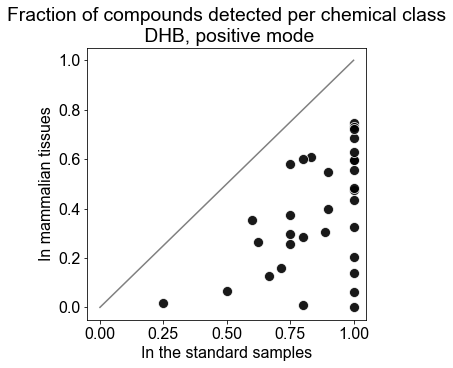

In [30]:
# Filter data
filtered_data = filter_data(dhb, 
                            adducts=['+H', '+Na', '+K'],
                            neutral_losses=[""])

# Calculate detectability per metabolite and dataset
molecule_data = group_by_molecule(filtered_data, groupby_columns=['name_short', 'origin', 'dataset_id'])

# Map chemical class to the metabolite
mapped_data = molecule_data.merge(chem_subclass, on='name_short', how='left')

# Summarise data per class (mean of detected metabolites, and fraction of detected ions per class)
class_data = summarise_per_class(mapped_data, groupby_columns=['origin', 'dataset_id', 'fine_class'])

# Zero-fill the data
zero_filled_data = zero_fill_data(class_data, classification=chem_subclass, class_col_name='fine_class')

# Calculate mean detectability among all datasets
plot_data = zero_filled_data.pivot_table(index='fine_class',
                                         columns='origin',
                                         values='value',
                                         aggfunc='mean')
 
# Make a plot
make_a_plot(plot_data, title='Fraction of compounds detected per chemical class\n DHB, positive mode')
plt.savefig(p_analysis/ f"Detections_in_spots_vs_tissue_DHB_ML.png")
plt.savefig(p_analysis/ f"Detections_in_spots_vs_tissue_DHB_ML.pdf")

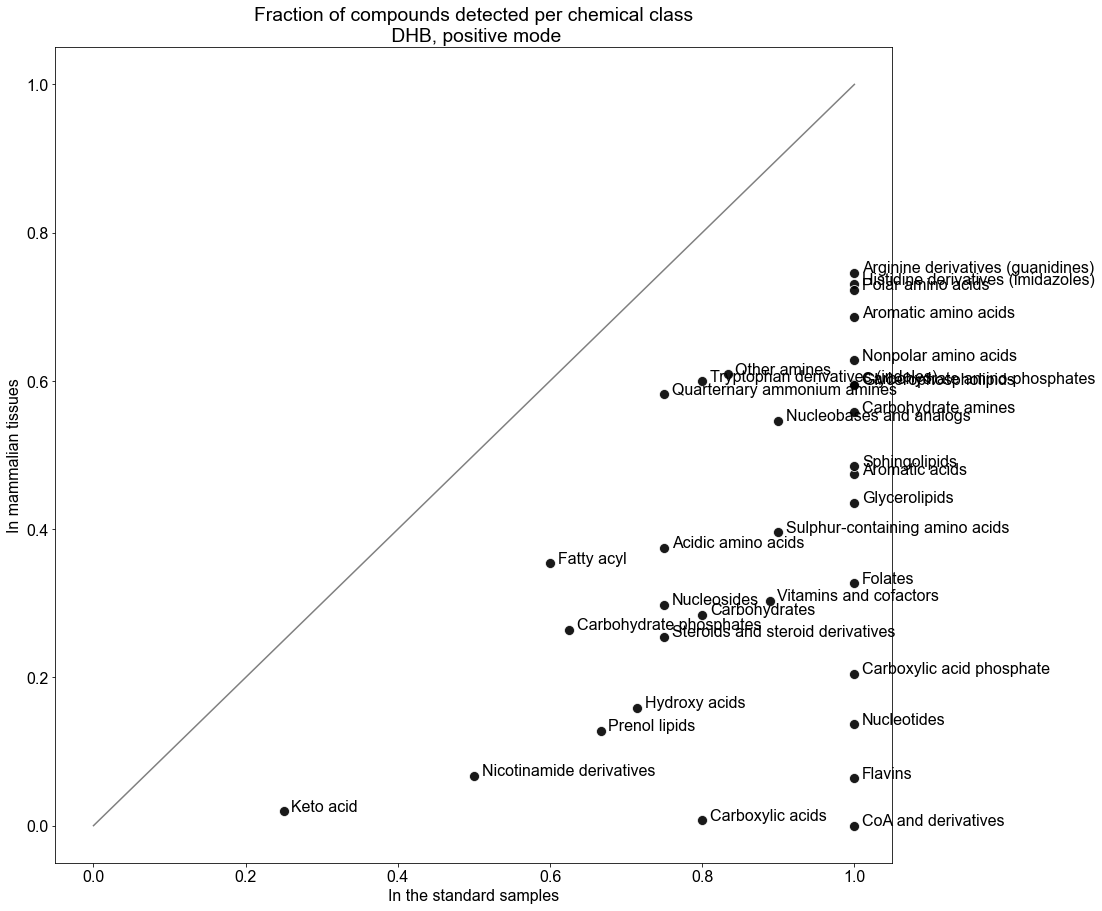

In [31]:
annotate_plot(plot_data, title='Fraction of compounds detected per chemical class\n DHB, positive mode')
plt.savefig(p_analysis/ f"Detections_in_spots_vs_tissue_DHB_ML_annotated.png")
plt.savefig(p_analysis/ f"Detections_in_spots_vs_tissue_DHB_ML_annotated.pdf")

- DAN

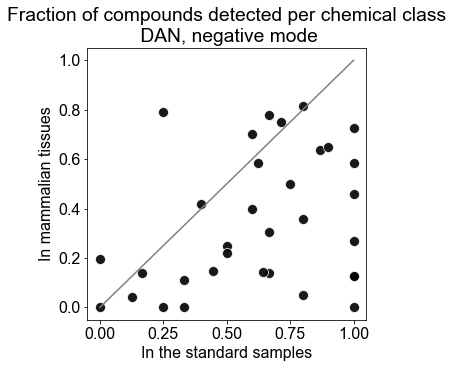

In [32]:
# Filter data
filtered_data = filter_data(dan, 
                            adducts=['-H', '+Cl'],
                            neutral_losses=[""]
                           )

# Calculate detectability per metabolite and dataset
molecule_data = group_by_molecule(filtered_data, groupby_columns=['name_short', 'origin', 'dataset_id'])

# Map chemical class to the metabolite
mapped_data = molecule_data.merge(chem_subclass, on='name_short', how='left')

# Summarise data per class (mean of detected metabolites, and fraction of detected ions per class)
class_data = summarise_per_class(mapped_data, groupby_columns=['origin', 'dataset_id', 'fine_class'])

# Zero-fill the data
zero_filled_data = zero_fill_data(class_data, classification=chem_subclass, class_col_name='fine_class')

# Calculate mean detectability among all datasets
plot_data = zero_filled_data.pivot_table(index='fine_class',
                                         columns='origin',
                                         values='value',
                                         aggfunc='mean')
 
# Make a plot
make_a_plot(plot_data, title='Fraction of compounds detected per chemical class\n DAN, negative mode')
plt.savefig(p_analysis/ f"Detections_in_spots_vs_tissue_DAN_ML.png")
plt.savefig(p_analysis/ f"Detections_in_spots_vs_tissue_DAN_ML.pdf")

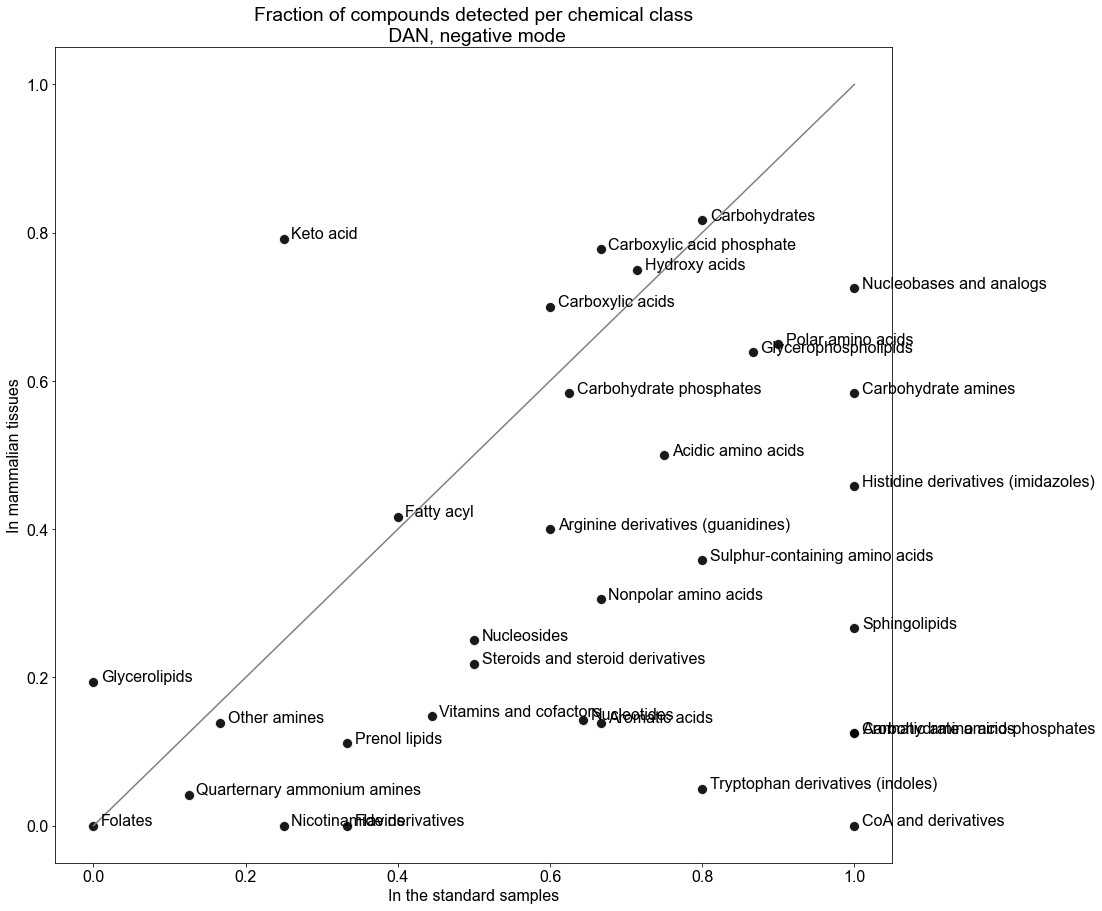

In [33]:
annotate_plot(plot_data, title='Fraction of compounds detected per chemical class\n DAN, negative mode')
plt.savefig(p_analysis/ f"Detections_in_spots_vs_tissue_DAN_ML_annotated.png")
plt.savefig(p_analysis/ f"Detections_in_spots_vs_tissue_DAN_ML_annotated.pdf")

## Same analysis, except tissue data was generated by manual ion image labelling

In [10]:
p_manual_labels = p_analysis / "manually_labelled_images_first_analysis_without_ML"

In [11]:
labelled_set = []

for img in (p_manual_labels / "pass").rglob("*.png"):
    filename = img.stem

    labelled_set.append({
        'old_id':img.stem[0:20],
        'formula':img.stem.split('_')[2],
        'adduct':img.stem.split('_')[3],
        'neutral_loss':'',
        'detectability':True
    })
        
manual_tissue_df = pd.DataFrame(labelled_set)

In [16]:
manual_tissue_df = manual_tissue_df.merge(tissue_metadata[['old_id', 'matrix', 'polarity', 'dataset_name']], on='old_id', how='left').rename(columns={'old_id':'dataset_id'})
manual_tissue_df['origin'] = 'tissue'
manual_tissue_df = manual_tissue_df.merge(name_map, on='formula', how='left')

#remove weird dataset
manual_tissue_df = manual_tissue_df.loc[manual_tissue_df.dataset_name!="20191021_Opt_Sanger_Brain_150sx75p_DANx_neg Cloned - extended"]

manual_tissue_dhb = manual_tissue_df[manual_tissue_df.matrix=='DHB'].drop(columns=['matrix', 'polarity', 'dataset_name'])
manual_tissue_dan = manual_tissue_df[manual_tissue_df.matrix=='DAN'].drop(columns=['matrix', 'polarity', 'dataset_name'])

In [55]:
# Combine spotting and tissue data in one datarame
manual_dhb = pd.concat([spots_dhb, manual_tissue_dhb])
manual_dan = pd.concat([spots_dan, manual_tissue_dan])

- DHB

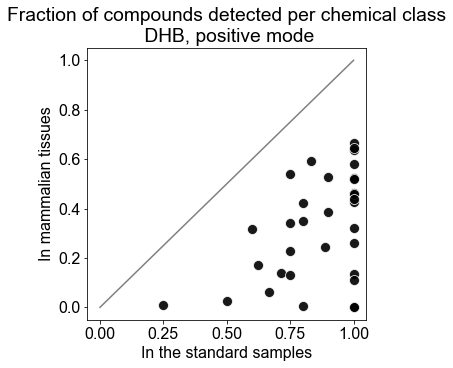

In [56]:
# Filter data
filtered_data = filter_data(manual_dhb, 
                            adducts=['+H', '+Na', '+K'],
                            neutral_losses=[""])

# Calculate detectability per metabolite and dataset
molecule_data = group_by_molecule(filtered_data, groupby_columns=['name_short', 'origin', 'dataset_id'])

# Map chemical class to the metabolite
mapped_data = molecule_data.merge(chem_subclass, on='name_short', how='left')

# Summarise data per class (mean of detected metabolites, and fraction of detected ions per class)
class_data = summarise_per_class(mapped_data, groupby_columns=['origin', 'dataset_id', 'fine_class'])

# Zero-fill the data
zero_filled_data = zero_fill_data(class_data, classification=chem_subclass, class_col_name='fine_class')

# Calculate mean detectability among all datasets
plot_data = zero_filled_data.pivot_table(index='fine_class',
                                         columns='origin',
                                         values='value',
                                         aggfunc='mean')
 
# Make a plot
make_a_plot(plot_data, title='Fraction of compounds detected per chemical class\n DHB, positive mode')
plt.savefig(p_analysis/ f"Detections_in_spots_vs_tissue_DHB_manual_labels.png")
plt.savefig(p_analysis/ f"Detections_in_spots_vs_tissue_DHB_manual_labels.pdf")

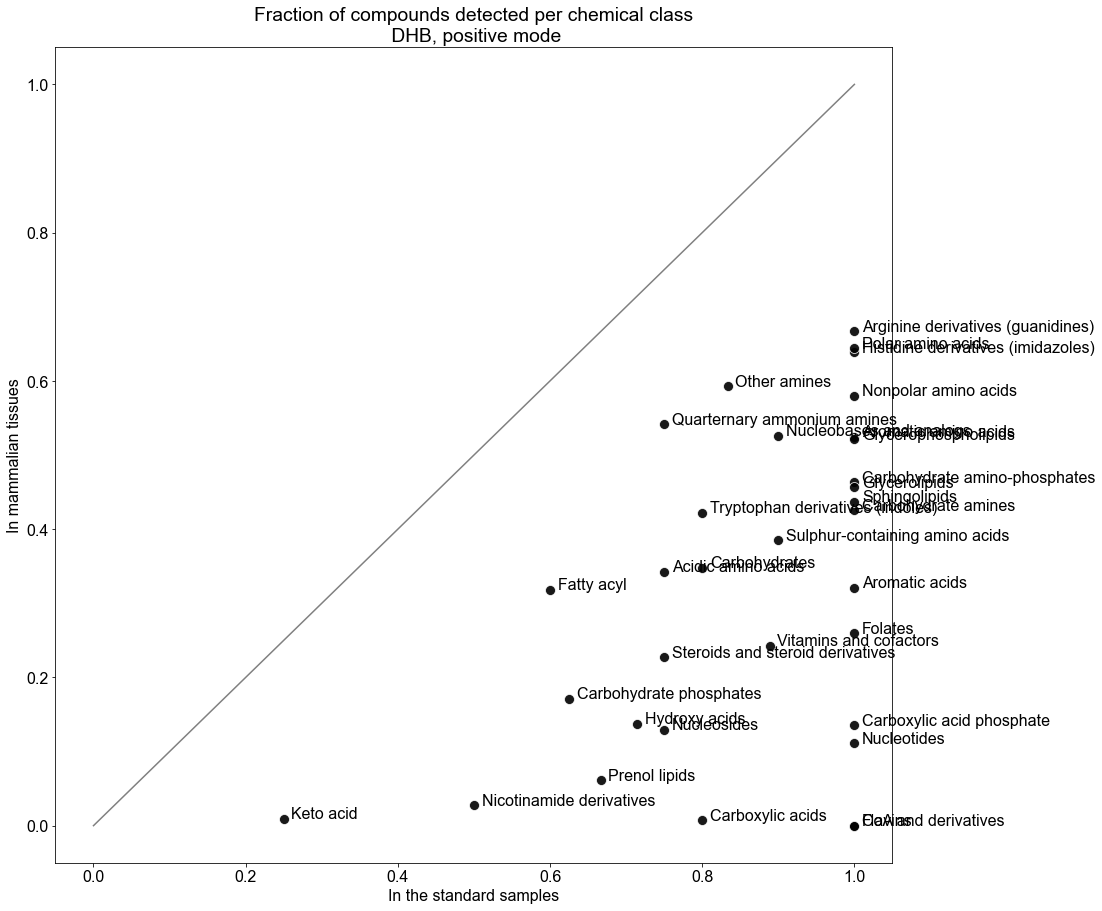

In [57]:
annotate_plot(plot_data, title='Fraction of compounds detected per chemical class\n DHB, positive mode')
plt.savefig(p_analysis/ f"Detections_in_spots_vs_tissue_DHB_manual_labels_annotated.png")
plt.savefig(p_analysis/ f"Detections_in_spots_vs_tissue_DHB_manual_labels_annotated.pdf")

- DAN

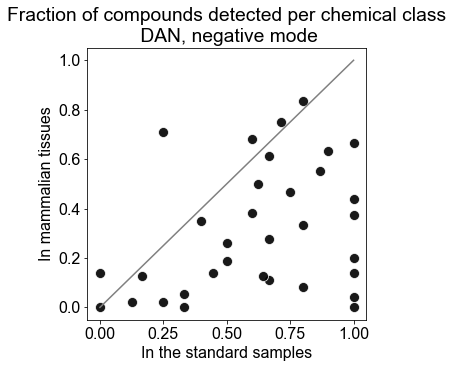

In [58]:
# Filter data
filtered_data = filter_data(manual_dan, 
                            adducts=['-H', '+Cl'],
                            neutral_losses=[""])

# Calculate detectability per metabolite and dataset
molecule_data = group_by_molecule(filtered_data, groupby_columns=['name_short', 'origin', 'dataset_id'])

# Map chemical class to the metabolite
mapped_data = molecule_data.merge(chem_subclass, on='name_short', how='left')

# Summarise data per class (mean of detected metabolites, and fraction of detected ions per class)
class_data = summarise_per_class(mapped_data, groupby_columns=['origin', 'dataset_id', 'fine_class'])

# Zero-fill the data
zero_filled_data = zero_fill_data(class_data, classification=chem_subclass, class_col_name='fine_class')

# Calculate mean detectability among all datasets
plot_data = zero_filled_data.pivot_table(index='fine_class',
                                         columns='origin',
                                         values='value',
                                         aggfunc='mean')
 
# Make a plot
make_a_plot(plot_data, title='Fraction of compounds detected per chemical class\n DAN, negative mode')
plt.savefig(p_analysis/ f"Detections_in_spots_vs_tissue_DAN_manual_labels.png")
plt.savefig(p_analysis/ f"Detections_in_spots_vs_tissue_DAN_manual_labels.pdf")

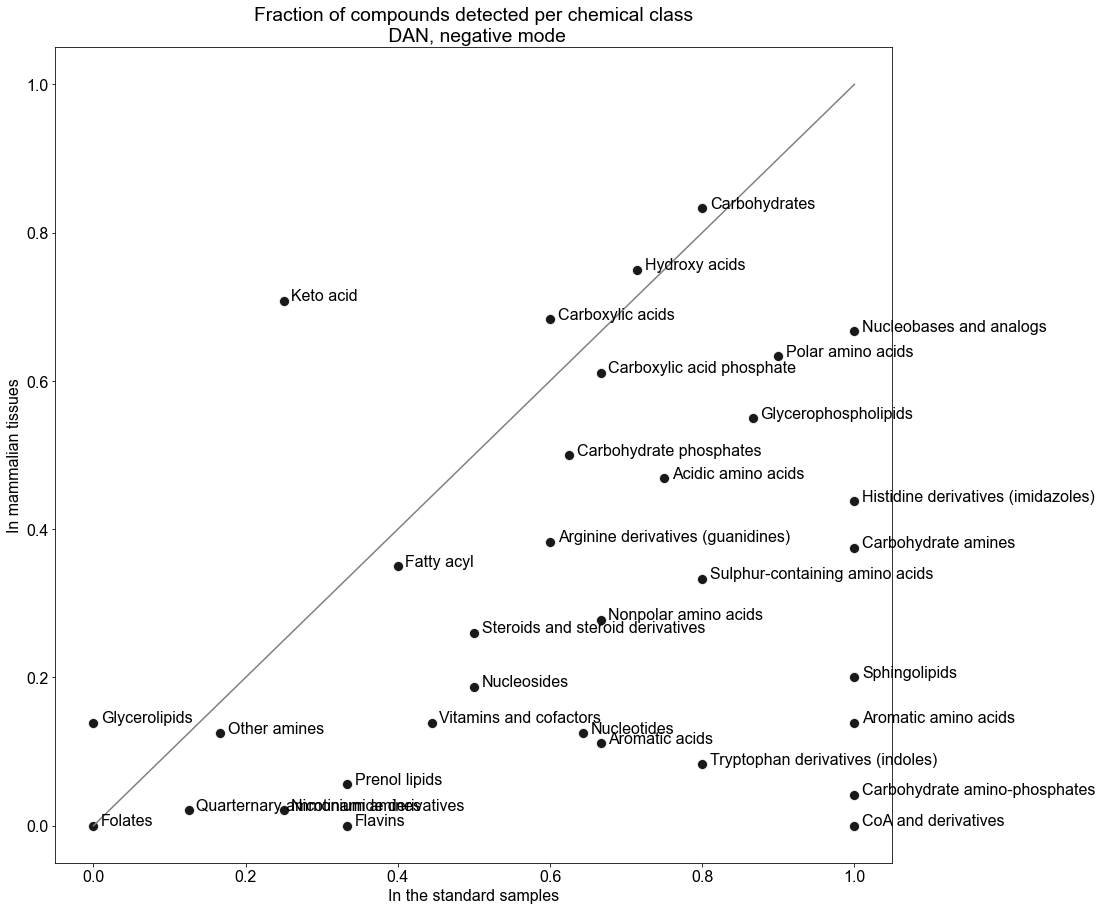

In [59]:
annotate_plot(plot_data, title='Fraction of compounds detected per chemical class\n DAN, negative mode')
plt.savefig(p_analysis/ f"Detections_in_spots_vs_tissue_DAN_manual_labels_annotated.png")
plt.savefig(p_analysis/ f"Detections_in_spots_vs_tissue_DAN_manual_labels_annotated.pdf")

In [60]:
### Verdict: results are pretty much the same with M and with labelling (no neutral losses), adding neutral losses doesn't add much
### For this reason and for simpicity it's probably best not to consider ML results with neutral losses at least if FDR is not included